# Key-Value Attention for Thai Karaoke Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [1]:
!pip install lightning wandb -q
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [2]:
!wandb login

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')
import torch
# import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

```
ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak
```


In [4]:
# !wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

In [5]:
import csv

with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [6]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [7]:
#Preprocessing
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))
data_size, vocab_size = len(name_th), len(input_chars)+1
output_vocab_size = len(output_chars)+2#+2 for special end of sentence token/PADDING
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
maxlen_out = len( max(name_en, key=len)) #max output length

There are 10887 lines and 65 unique characters in your input data.


In [8]:
# Written by Jeans
maxlen_out += 1 # add 1 for <EOW> token???

#create  (EMBEDDING)  dictionaries to convert character to integer and vice versa
input_chars = ['<PAD>'] + sorted(input_chars)
output_chars = ['<PAD>','<EOW>'] + sorted(output_chars)
# print(input_chars)
input_char_to_idx = { char: idx for idx, char in enumerate(input_chars)}
input_idx_to_char = { idx: char for idx, char in enumerate(input_chars)}
input_encode = lambda x: [input_char_to_idx[char] for char in x]
input_decode = lambda l: [input_idx_to_char[idx] for idx in l]

output_char_to_idx = { char: idx for idx, char in enumerate(output_chars)}
output_idx_to_char = { idx: char for idx, char in enumerate(output_chars)}
output_encode = lambda x: [output_char_to_idx[char] for char in x]
output_decode = lambda l: [output_idx_to_char[idx] for idx in l]

# Example
print("Example:")
print(input_encode("คนดำโครตเก่ง"))
print(input_decode(input_encode("คนดำโครตเก่ง")))

# print("Encoder Mapper:")
# print(input_char_to_idx)

# print("Decoder Mapper:")
# print(output_char_to_idx)


#PROCESS DATA FOR MODEL
# tokenize and embed inputs
# tokenize and embed outputs
# pad inputs
X = []
for word in name_th:
    word = [char for char in word]
    X.append(torch.tensor(input_encode(word))) # convert to tensor shape (len(X), len(word))
X = nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=0) # pad all sequences to same length with 0 : <PAD>

Y = []
for word in name_en:
    word = [char for char in word] + ['<EOW>']
    Y.append(torch.tensor(output_encode(word))) # convert to tensor shape (len(Y), len(word))
Y = nn.utils.rnn.pad_sequence(Y, batch_first=True, padding_value=0).long() # pad all sequences to same length with 0 : <PAD>
print("\nCheck X and Y of dataset")
print(X.shape)
print(Y.shape)
print("\nExample:")
print(X[0], "\n", input_decode(list(X[0].detach().numpy().astype(int)))) # 0 is the first word in the dataset)
print(Y[0], "\n", output_decode(list(Y[0].detach().numpy().astype(int)))) # 0 is the first word in the dataset)

Example:
[4, 24, 19, 47, 56, 4, 34, 20, 54, 2, 60, 6]
['ค', 'น', 'ด', 'ำ', 'โ', 'ค', 'ร', 'ต', 'เ', 'ก', '่', 'ง']

Check X and Y of dataset
torch.Size([10887, 20])
torch.Size([10887, 20])

Example:
tensor([58,  2, 34, 39, 49, 40, 64,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]) 
 ['ไ', 'ก', 'ร', 'ส', 'ี', 'ห', '์', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
tensor([12, 18,  3, 11, 19, 11,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]) 
 ['k', 'r', 'a', 'i', 's', 'i', '<EOW>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [9]:
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 20


In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:
class NameDataset(Dataset):
  def __init__(self, X, y):
    #FILL CODE HERE pass
    self.encoded_X = X.long()
    self.encoded_label = y

  def __getitem__(self, idx):
    #FILL CODE HERE pass
    return {"x" :self.encoded_X[idx], "y":self.encoded_label[idx]}

  def __len__(self):
    #FILL CODE HERE pass
    return len(self.encoded_X)

In [12]:
class NameDataModule(L.LightningDataModule):

  def __init__(self, train_data, y, batch_size, num_workers=0):
      super().__init__()
      self.train_data = train_data
      self.y = y
      self.batch_size = batch_size
      self.num_workers = num_workers


  def setup(self, stage: str):
    pass

  def collate_fn(self, batch):
    '''turn encoded inputs into one-hot vectors'''
    batched_one_hot_x = torch.stack([F.one_hot(dp["x"], num_classes=vocab_size) for dp in batch])
    batched_y = torch.stack([dp["y"] for dp in batch])
    return {"x": batched_one_hot_x.float(), "y": batched_y}    

  def train_dataloader(self):
    train_dataset = NameDataset(self.train_data, self.y)
    train_loader = DataLoader(train_dataset,
                                batch_size = self.batch_size,
                                shuffle = True,
                                collate_fn = self.collate_fn,
                                num_workers = self.num_workers)
    return train_loader


# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [13]:
def one_step_attention(h, s_prev, attention_layer, key_ff_layer):
    '''
    h.shape = (batch_size, seq_len, hidden_size)
    '''
    #Split into Key-Value
    key, value = torch.split(h, h.shape[2]//2, dim=2) # (b, seq_len, hidden_size//2)
    #do concat with s_prev.
    #hint: you will need to use s_prev.repeat(...) somehow so that it has the same dimension as the key
    #hint2: s_prev.unsqueeze() could also be useful
    s_prev = s_prev.unsqueeze(1).repeat((1, h.shape[1], 1))
    concatenated = torch.cat((key, s_prev), dim=2) # (b, seq_len, hidden_size)

    #Attention function###
    # use layer(s) from your model to calculate attention_scores and then softmax
    # calculate a context vector
    f_attn = F.tanh(attention_layer(concatenated)) # (b, seq_len, 1)
    f_attn = F.relu(key_ff_layer(f_attn)) # (b, seq_len, 1)
    
    attention_scores = F.softmax(f_attn, dim=1) # (b, seq_len, 1)
    
    tmp = torch.mul(attention_scores, value) # (b, seq_len, hidden_size//2)
    context = torch.sum(tmp,dim=1)
    
    return context, attention_scores

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [14]:
class AttentionModel(L.LightningModule):
    def __init__(self, learning_rate, criterion):

        super().__init__()
        self.n_h = 64 #hidden dimensions for encoder
        self.n_s = 64 #hidden dimensions for decoder

        #encoder can be any RNN of your choice
        bi_direction = True
        self.num_directions = 2 if bi_direction else 1
        self.lstm = nn.LSTM(len(input_char_to_idx), self.n_h, bidirectional=bi_direction, batch_first=True)
        #decoder has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        self.decoder_lstm_cell = nn.LSTMCell(self.n_s, self.n_s)
        self.output_layer = nn.Linear(self.n_s, len(output_char_to_idx))
        #attention
        self.attention_layer = nn.Linear((self.n_h//2)*2*self.num_directions, (self.n_h//2))
        self.key_ff_layer = nn.Linear((self.n_h//2), 1)
        
        self.learning_rate = learning_rate
        self.criterion = criterion

    def forward(self, src, return_attention=False): #use return_attention only when you want to get the attention scores for visualizing
        #pass the input to the encoder
        lstm_out, _ = self.lstm(src)
        #Initialize the LSTM states. We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        #These states will get updated while we are decoding
        decoder_s = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)
        decoder_c = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)

        #Iterate until max_output_length (Decoding)
        prediction = torch.zeros((src.shape[0], maxlen_out, len(output_char_to_idx))).to(self.decoder_lstm_cell.weight_ih.device)
        attention_scores = [] #to store the score for each step
        for t in range(maxlen_out):
            
            #Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(lstm_out, decoder_s, self.attention_layer, self.key_ff_layer)
            #prep for visualization
            attention_scores.append(attention_score.detach().cpu().numpy())

            # Feed the context vector to the decoder.
            decoder_s, decoder_c = self.decoder_lstm_cell(context, (decoder_s, decoder_c))
            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)
            # Put the predicted output into the list for this timestep
            prediction[:, t] = out

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src = batch['x']
        target = batch['y']
        prediction,_ = self(src)
        prediction = prediction.reshape(-1, len(output_char_to_idx))
        target = target.reshape(-1)
        loss = self.criterion(prediction, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        src = batch['x']
        with torch.no_grad():
          prediction, attention_scores = self(src, return_attention=True)
          prediction = F.softmax(prediction, dim=-1)
          prediction = torch.argmax(prediction, dim=-1)
          for pred in prediction:
            # print("".join(output_char_to_idx.lookup_tokens(pred.cpu().numpy())))
            print("".join(output_decode(pred.cpu().numpy())))
            
        return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [15]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
model = AttentionModel(lr, criterion)

In [16]:
data_module = NameDataModule(X, Y, batch_size=4096)

In [17]:
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="hw3.1_attention")

In [18]:
trainer = L.Trainer(
    max_epochs=1000,
    logger=wandb_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | lstm              | LSTM             | 67.1 K | train
1 | decoder_lstm_cell | LSTMCell         | 33.3 K | train
2 | output_layer      | Linear           | 1.6 K  | train
3 | attention_layer   | Linear           | 4.1 K  | train
4 | key_ff_layer      | Linear           | 33     | train
5 | criterion         | CrossEntropyLoss | 0      | train
---------------------------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/home/jaf/anaconda3/envs/nlp/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of th

Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 10.36it/s, v_num=ss6m]   

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00,  9.95it/s, v_num=ss6m]


# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

Example Output:
```
prayutthatha</s></s>aa</s></s>a</s>
somchai</s></s></s></s>a</s></s>a</s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s></s>
newin</s>i</s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s>he</s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s>i</s></s></s></s>
```

<font color='blue'>Paste your model predictions in MyCourseVille</font>

In [20]:
EXAMPLES = ['ประยุทธ','สมชาย','ธนาธร','เนวิน','สุเทพ','ประวิตร์','ชัชชาติ']

#Writenn by Jeans

predict_data = []
for line in EXAMPLES:
    line = [l for l in line] #change from string to list
    predict_data.append(torch.tensor(input_encode(line)))
predict_data_with_pad = nn.utils.rnn.pad_sequence(predict_data, batch_first=True, padding_value=0) # pad all sequences to same length with 0 : <PAD>

print(len(predict_data))

def collate_fn_(batch):
    batched_one_hot_x = torch.stack([F.one_hot(dp["x"], num_classes=vocab_size) for dp in batch])
    return {"x": batched_one_hot_x.float()}    

predict_data = nn.utils.rnn.pad_sequence(predict_data, batch_first = True)
predict_dataset = NameDataset(predict_data, [torch.tensor(0)]*len(predict_data))
predict_loader = DataLoader(predict_dataset,
                          batch_size = 1,
                          shuffle = False,
                          collate_fn = collate_fn_,
                          num_workers = 1)

7


In [21]:
model.eval()

AttentionModel(
  (lstm): LSTM(65, 64, batch_first=True, bidirectional=True)
  (decoder_lstm_cell): LSTMCell(64, 64)
  (output_layer): Linear(in_features=64, out_features=24, bias=True)
  (attention_layer): Linear(in_features=128, out_features=32, bias=True)
  (key_ff_layer): Linear(in_features=32, out_features=1, bias=True)
  (criterion): CrossEntropyLoss()
)

In [22]:
output = trainer.predict(model, predict_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jaf/anaconda3/envs/nlp/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 93.14it/s]


## TODO 5: Show your visualization of attention scores on one of your example

<font color='blue'>Paste your visualization image in MyCourseVille</font>

In [23]:
for i, pred in enumerate(output):
    # print(len(pred))
    embedding , attention = pred
    word = output_decode(list(embedding.detach().numpy()[0]))
    word = ''.join(word).replace('<EOW>', '~').replace('<PAD>', '_')
    print(EXAMPLES[i], word)
    # print("Attention", attention[0].detach().numpy().shape)
# output

ประยุทธ prayutthata_________
สมชาย somchai~____________
ธนาธร thanathong__________
เนวิน nowing______________
สุเทพ suthep~_____________
ประวิตร์ prawit~_____________
ชัชชาติ chatchccccattt~_____


In [24]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
prediction, attention_scores = zip(*output)


(20, 1, 8, 1)
(20, 8)
['p', 'r', 'a', 'y', 'u', 't', 't', 'h', 'a', 't', 'a', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['ป', 'ร', 'ะ', 'ย', 'ุ', 'ท', 'ธ', '<PAD>']


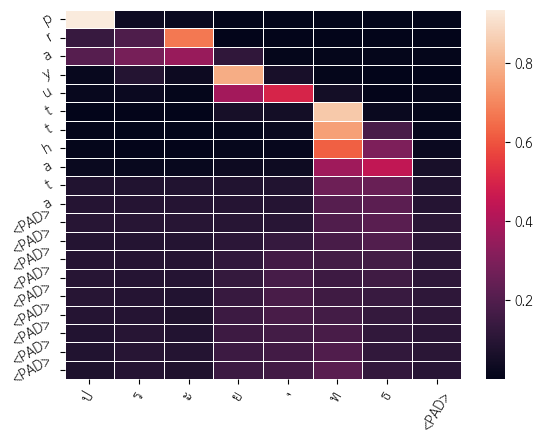

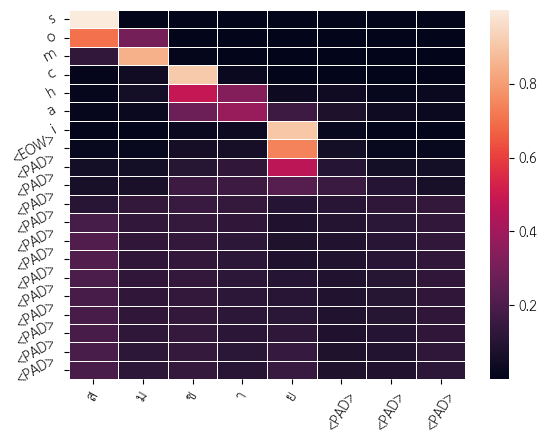

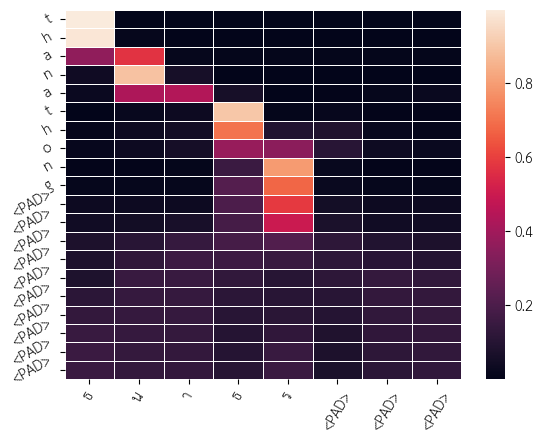

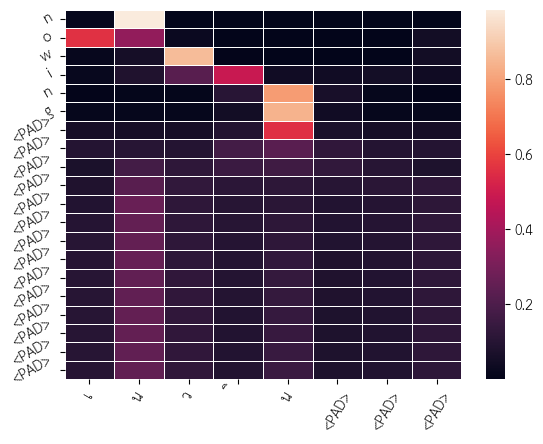

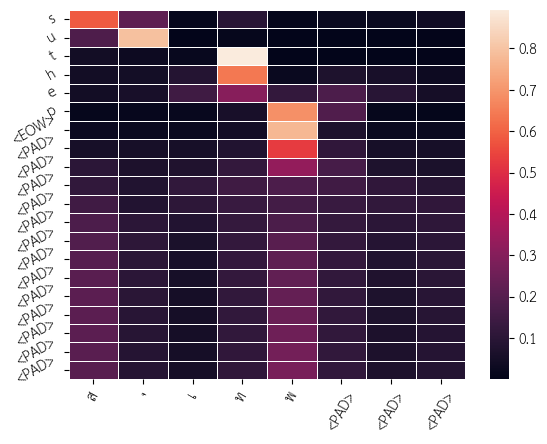

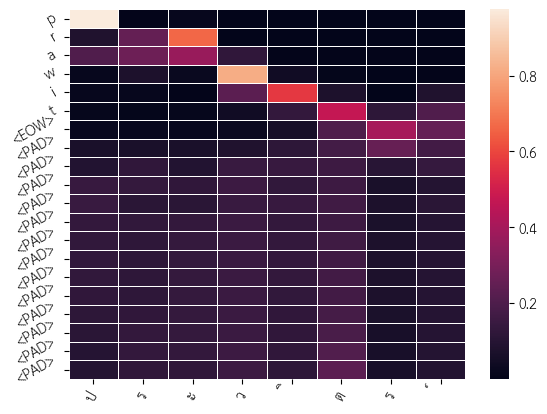

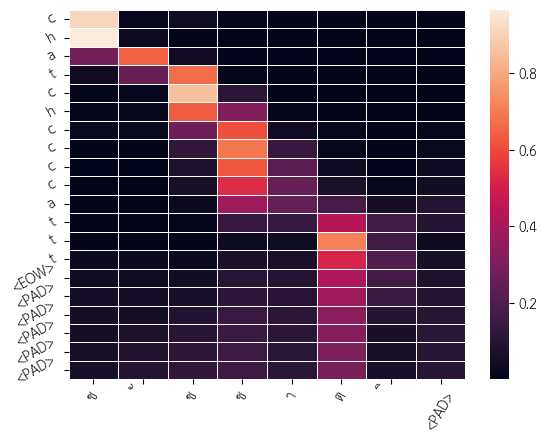

In [30]:
for samp_index , (pred, attn) in enumerate(zip(prediction, attention_scores)):

    sample_attention = np.array(attention_scores)[samp_index]
    attn_viz = sample_attention.reshape((maxlen_out, -1))
    # print(sample_attention.shape)
    # print(attn_viz.shape)

    sample_prediction = prediction[samp_index].detach().numpy().squeeze()
    output_text = output_decode(list(sample_prediction))
    # print(output_text)

    xlabels = [c for c in EXAMPLES[samp_index]] + ['<PAD>']*(attn_viz.shape[1] - len(EXAMPLES[samp_index]))
    # print(xlabels)

    ax = sns.heatmap(attn_viz, linewidth=0.5)
    ax.set_yticklabels(output_text,rotation=30)
    ax.set_xticklabels(xlabels,rotation=60)
    plt.show()